## silicon slab transmission

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

# fitter plugins
from tidy3d.plugins.dispersion import FastDispersionFitter as Fitter

In [2]:
fitter = Fitter.from_url('https://refractiveindex.info/data_csv.php?datafile=database/data-nk/main/Si/Green-2008.yml')
fitter = fitter.copy(update={'wvl_range' : (0.4, 1.2)}) #um

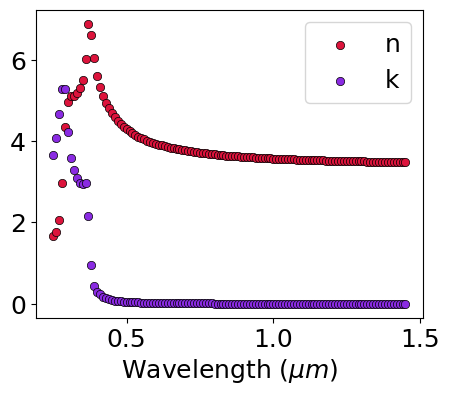

In [3]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,figsize=(5,4))
ax.scatter(fitter.wvl_um, fitter.n_data, label='n', color='crimson', edgecolors='black', linewidth=0.5)
ax.scatter(fitter.wvl_um, fitter.k_data, label='k', color='blueviolet', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Wavelength ($\mu m$)')
ax.legend()
plt.show()

In [4]:
medium, rms_error = fitter.fit(max_num_poles=2, tolerance_rms=5e-2)
medium = medium.copy(update={'name':"fitted silicon"})

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

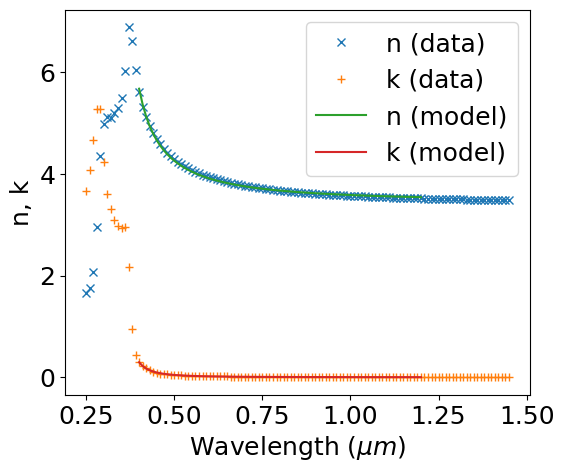

In [5]:
fig, ax = plt.subplots(1,figsize=(6,5))
fitter.plot(medium,ax=ax)
plt.show()

In [6]:
# Wavelength and frequency range
lambda_range = (0.4, 1.2)
lam0 = np.sum(lambda_range)/2
freq_range = (td.constants.C_0/lambda_range[1], td.constants.C_0/lambda_range[0])

# frequencies and wavelengths of monitor
Nfreq = 333
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# central frequency, frequency pulse width and total running time
freq0 = monitor_freqs[Nfreq // 2]
freqw  = 0.3 * (freq_range[1] - freq_range[0])
t_stop = 100 / freq0

# Thicknesses of slabs
t_slabs = [1.0] # um

# medium of slabs
mat_slabs = [medium]

# space between slabs and sources and PML
spacing = 1 * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (1, 1, 4*spacing + sum(t_slabs))

In [7]:
# First, we define the multilayer stack structure (a single layer in this example).
slabs = []
slab_position = -Lz/2 + 2*spacing
count_slab = 0
for t, mat in zip(t_slabs, mat_slabs):
    slab = td.Structure(
        geometry=td.Box(
            center=(0, 0, slab_position + t/2),
            size=(td.inf, td.inf, t),
        ),
        medium=mat,
        name='slab'+ str(count_slab),
    )
    slabs.append(slab)
    slab_position += t
    count_slab += 1

# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freqw
    ),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz/2+spacing*1.5),
    direction='+',
    pol_angle=0,
    name='planewave',
)

# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
monitor = td.FluxMonitor(
    center = (0, 0, Lz/2 - spacing),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    name='trans',
)

In [8]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30),
    structures = slabs,
    sources = [source],
    monitors = [monitor],
    run_time = t_stop,
    boundary_spec = td.BoundarySpec.pml(z=True),
)

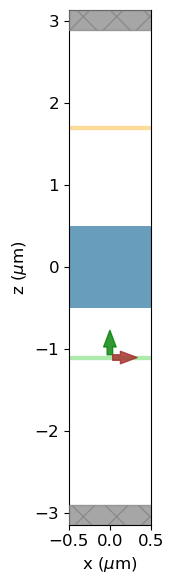

In [9]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1, tight_layout=True, figsize=(4, 6))
sim.plot(y=0, freq=freq0, ax=ax);
ax.set_title('')
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('z ($\mu$m)')
plt.show()

In [10]:
sim_data = web.run(sim, task_name='lecture05_silicon', path='data/data_silicon.hdf5')

23:52:47 +07 Created task 'lecture05_silicon' with task_id                      
             'fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=54081;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=429308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\taskId]8;;\]8;id=54081;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\=]8;;\]8;id=631822;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\fdve]8;;\]8;id=54081;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\-815fae70-834]8;;\
             ]8;id=54081;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\f-4b65-a3ee-4cdda4d16e14']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

23:52:51 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

23:52:56 +07 status = preprocess

23:52:57 +07 Maximum FlexCredit cost: 0.154. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

23:52:58 +07 running solver

23:53:16 +07 early shutoff detected at 76%, exiting.

23:53:17 +07 status = success

             View simulation result at                                          
             ]8;id=753022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=219145;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\taskId]8;;\]8;id=753022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\=]8;;\]8;id=896057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\fdve]8;;\]8;id=753022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\-815fae70-834]8;;\
             ]8;id=753022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-815fae70-834f-4b65-a3ee-4cdda4d16e14\f-4b65-a3ee-4cdda4d16e14']8;;\.

23:53:19 +07 loading simulation from data/data_silicon.hdf5

In [12]:
# import TMM package
import tmm

# prepare list of thicknesses including air boundaries
d_list = [np.inf] + t_slabs + [np.inf]

# loop through wavelength and record TMM computed transmission
transmission_tmm = []
for i, lam in enumerate(monitor_lambdas):

    # create list of refractive index at this wavelength including outer material (air)
    n_list = [1, np.sqrt(medium.eps_model(td.C_0/lam)), 1]

    # get transmission at normal incidence
    T = tmm.coh_tmm('s', n_list, d_list, 0, lam)['T']
    transmission_tmm.append(T)

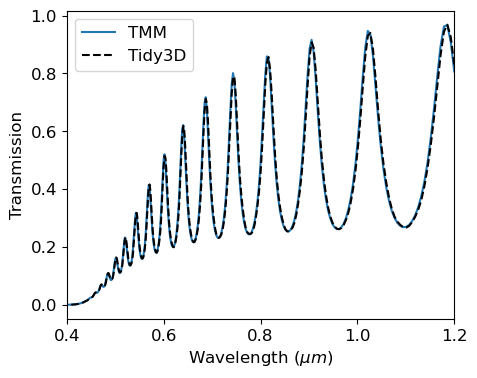

In [13]:
transmission = sim_data['trans'].flux
fig, ax = plt.subplots(1,figsize=(5,4))

ax.plot(monitor_lambdas, transmission_tmm, '-', label='TMM')
ax.plot(monitor_lambdas, transmission, 'k--', label='Tidy3D')
ax.set_xlabel('Wavelength ($\mu m$)')
ax.set_ylabel('Transmission')
ax.set_xlim(fitter.wvl_range)
ax.legend()
plt.show()